In [1]:
import glob
import numpy as np
from PIL import Image, ImageDraw
from typing import Tuple
import os
import platform
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from sklearn.cluster import KMeans
import shutil
from ezdxf.addons import r12writer

# Check versions
print("Python Version:", platform.python_version())
print("Installed PIL.Image Version:", Image.__version__)
print("Installed Numpy Version:", np.__version__)
print("Installed Ipywidgets Version:", widgets.__version__)

Python Version: 3.9.7
Installed PIL.Image Version: 8.4.0
Installed Numpy Version: 1.21.2
Installed Ipywidgets Version: 7.6.5


Select the file from the current directory using [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20List.html#Selection-widgets), and [import image as a numpy array](https://www.geeksforgeeks.org/how-to-convert-images-to-numpy-array/).

In [2]:
files = glob.glob(".//**//[!_]*")
imageSelector = widgets.Dropdown(
    options=files,
    description="Files",
    disabled=False,
    value=".\memes\FrankReynolds.jpg"
)

display(imageSelector)

Dropdown(description='Files', index=7, options=('.\\basic\\aaaaaSimple.jpg', '.\\basic\\SomeShapes.jpg', '.\\F…

The numpy array has shape (1080, 1920, 3)


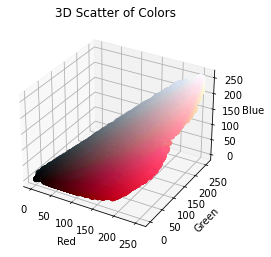

In [3]:
# load the image and convert into
# numpy array
img = Image.open(imageSelector.value)
  
# asarray() class is used to convert
# PIL images into NumPy arrays
arr = np.asarray(img)
print("The numpy array has shape", arr.shape)

# Plot the Color in the image
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# defining axes
x = arr[:, :, 0].flatten()
y = arr[:, :, 1].flatten()
z = arr[:, :, 2].flatten()
ax.scatter(x, y, z, c=arr.reshape(-1, 3)/255)
 
# syntax for plotting
ax.set_title("3D Scatter of Colors")
ax.set_xlabel("Red")
ax.set_ylabel("Green")
ax.set_zlabel("Blue")
plt.show()

In [4]:
# Slider for number of colors (centers) in clustering
numColorsSlider = widgets.IntRangeSlider(
    value=[5, 5],
    min=1,
    max=10,
    step=1,
    description='Number Colors:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

display(numColorsSlider)

IntRangeSlider(value=(5, 5), continuous_update=False, description='Number Colors:', max=10, min=1)

In [5]:
# K-Means Clustering for primary colors in image

# Create a folder for formatted images
directory = ".//FormattedImages"
clusteredDirectory = "ClusteredImages"
try:
    shutil.rmtree(directory)
except:
    pass

os.makedirs(directory)
os.makedirs(os.path.join(directory, clusteredDirectory))

# Format header of table
table = "| Number Colors | K-Means |"
table = "{}\n| :---: | :---: |".format(table)

# The min and max number of clusters
minClusters = numColorsSlider.value[0]
maxClusters = numColorsSlider.value[1]

# A 4D array to save the processed clusters
proccessedArrs = np.zeros((arr.shape[0], arr.shape[1], arr.shape[2], maxClusters - minClusters + 1)).astype('uint8')

# Do k-means clustering
for n_clusters in range(minClusters, maxClusters + 1, 1):
    model = KMeans(n_clusters=n_clusters)
    predictions = model.fit_predict(arr.reshape(-1, 3))
    newArr = np.zeros((predictions.shape[0], 3))
    for i, predicted_cluster in enumerate(predictions):
        newArr[i, :] = model.cluster_centers_[predicted_cluster, :]
    newArr = newArr.reshape(arr.shape)
    newArr = newArr.round().astype('uint8')
    proccessedArrs[:, :, :, n_clusters - minClusters] = newArr
    newPic = Image.fromarray(newArr)
    filename = "{}//{}//_NumClusters_{}.jpg".format(directory, clusteredDirectory, n_clusters)
    newPic.save(filename)
    table = "{}\n| {} | ![]({}) |".format(table, n_clusters, filename)

# Add the original image to the table
table = "{}\n| Original | ![]({}) |\n".format(table, imageSelector.value)

display(Markdown(table))

| Number Colors | K-Means |
| :---: | :---: |
| 5 | ![](.//FormattedImages//ClusteredImages//_NumClusters_5.jpg) |
| Original | ![](.\memes\FrankReynolds.jpg) |


We'll define some useful classes for keeping track of our image.

In [26]:
class BenDayDot():
    def __init__(self, diameter: int, center: Tuple[int, int], color: Tuple[int, int, int]) -> None:
        self.diameter = diameter
        self.center = center
        self.color = tuple([int(color[0]), int(color[1]), int(color[2])])

class BenDayPainting():
    def __init__(self, n_clusters: int, colorSpread: int, smallestDotSize: int, dimensions: Tuple[int, int]) -> None:
        self.benDayDots = list()
        self.n_clusters = n_clusters
        self.colorSpread = colorSpread
        self.smallestDotSize = smallestDotSize
        self.dimensions = dimensions
    
    def AddDot(self, center: Tuple[int, int], diameter: int, subArr: np.ndarray) -> None:
        # Make calculations by flattening out and finding the mode row
        uniqueColors, counts = np.unique(subArr.reshape(-1, subArr.shape[2]), return_counts=True, axis=0)
        modeColor = uniqueColors[np.argmax(counts), :]
        newDot = BenDayDot(diameter, center, modeColor)
        self.benDayDots.append(newDot)
    
    def makeImage(self, filename: str) -> None:
        # https://www.blog.pythonlibrary.org/2021/02/23/drawing-shapes-on-images-with-python-and-pillow/
        # Use ImageDraw ellipse
        image = Image.new("RGB", (self.dimensions[1], self.dimensions[0]), "white")
        draw = ImageDraw.Draw(image)

        # Draw a dot for each dot
        for dot in self.benDayDots:
            radius = int(dot.diameter / 2)
            upper_left_x = dot.center[0] - radius
            upper_left_y = dot.center[1] - radius
            lower_right_x = dot.center[0] + radius
            lower_right_y = dot.center[1] + radius
            draw.ellipse( ( (upper_left_x, upper_left_y), (lower_right_x, lower_right_y) ), fill=dot.color)
        image.save(filename)
    
    def makeDXFs(self, filename: str) -> None:
        # https://ezdxf.readthedocs.io/en/stable/addons/r12writer.html#r12writer
        # Seperate the circles into lists of different clusters
        uniqueColorSets = dict()
        for dot in self.benDayDots:
            colorSet = uniqueColorSets.get(dot.color, set())
            colorSet.add(dot)
            uniqueColorSets[dot.color] = colorSet
        
        # Make an empty white layer
        uniqueColorSets[(255, 255, 255)] = set()

        # Iterate over each cluster writing the dots to a unique filename
        for color, colorDotsSet in uniqueColorSets.items():
            colorFilename = "{}_{}.dxf".format(filename, color)
            with r12writer(colorFilename) as dxf:
                # Draw a circle where the dot *doesn't* exist
                for dot in self.benDayDots:
                    if dot not in colorDotsSet:
                        dxf.add_circle(dot.center, radius=dot.diameter/2)

This helper will recursively create the image by sub dividing an image into roughly squares until we've either reached the a small enough color spread or are at the smallest dot size.

In [27]:
# Ben Day Dots in convolutions and recursion
def benDayDotHelper(minX: int, maxX: int, minY: int, maxY: int, arr: np.ndarray, benDayPainting: BenDayPainting) -> None:
    # Check if base case
    subArr = arr[minY:maxY, minX:maxX, :]
    subHeight = subArr.shape[0]
    subWidth = subArr.shape[1]
    diameter = min(subHeight, subWidth)
    # Calculate center
    centerX = np.round(minX + (subWidth / 2))
    centerY = np.round(minY + (subHeight / 2))
    center = (centerX, centerY)
    if diameter <= benDayPainting.smallestDotSize:
        # Base case: Dot is too small to go further
        benDayPainting.AddDot(center, diameter, subArr)
        return
    # Check spread
    subSpread = np.std(subArr)
    if subSpread <= benDayPainting.colorSpread:
        # Base case: Dot is uniform enough in color
        benDayPainting.AddDot(center, diameter, subArr)
        return
    
    # Otherwise divide into smaller roughly squares
    if subHeight > subWidth:
        numColumns = 1
        numRows = 2
    else:
        numColumns = 2
        numRows = 1
    while True:
        columnWidth = subWidth / numColumns
        rowHeight = subHeight / numRows
        ratio = columnWidth / rowHeight
        if ratio < (4/5):
            numRows += 1
        elif ratio > (5/4):
            numColumns += 1
        else:
            break
    
    # Split into sub arrays and recurse
    for column_i in range(numColumns):
        for row_i in range(numRows):
            new_minX = int(column_i * subWidth/numColumns) + minX
            new_maxX = int((column_i + 1) * subWidth/numColumns) + minX
            new_minY = int(row_i * subHeight/numRows) + minY
            new_maxY = int((row_i + 1) * subHeight/numRows) + minY
            benDayDotHelper(new_minX, new_maxX, new_minY, new_maxY, arr, benDayPainting)

In [28]:
# Select a subset of the colors clusters
newNumColorsSlider = widgets.IntRangeSlider(
    value=[numColorsSlider.value[0], numColorsSlider.value[1]],
    min=numColorsSlider.value[0],
    max=numColorsSlider.value[1],
    step=1,
    description='Number Colors to process:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

#  Slect the step size of the slider
colorSpreadStepper = widgets.Dropdown(
    options=[5, 10, 25, 50, 100],
    value=5,
    description='Color Step:',
    disabled=False,
)
# Slider for allowable spread of colors
colorSpreadSlider = widgets.IntRangeSlider(
    value=[30,30],
    min=0,
    max=300,
    description='Color Spread:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)
# Link the slider's step size and dropdown's value
widgets.link((colorSpreadStepper, 'value'), (colorSpreadSlider, 'step'))

# Derive basic image properties for dot size
imageHeight = arr.shape[0]
imageWidth = arr.shape[1]
minDimension = min(imageHeight, imageWidth) 

dotStepper = widgets.Dropdown(
    options=[5, 10, 25, 50, 100],
    value=10,
    description='Dot Step:',
    disabled=False,
)

# Slider for min dot size
smallestDotSizeSlider = widgets.IntRangeSlider(
    value=[30,30],
    min=10,
    max=minDimension,
    description='Smallest Dot Diameter:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

widgets.link((dotStepper, 'value'), (smallestDotSizeSlider, 'step'))

display(newNumColorsSlider)
display(colorSpreadStepper)
display(colorSpreadSlider)
display(dotStepper)
display(smallestDotSizeSlider)

IntRangeSlider(value=(5, 5), continuous_update=False, description='Number Colors to process:', max=5, min=5)

Dropdown(description='Color Step:', options=(5, 10, 25, 50, 100), value=5)

IntRangeSlider(value=(30, 30), description='Color Spread:', max=300, step=5)

Dropdown(description='Dot Step:', index=1, options=(5, 10, 25, 50, 100), value=10)

IntRangeSlider(value=(30, 30), continuous_update=False, description='Smallest Dot Diameter:', max=1080, min=10…

Finally, put the above few cells together and save the files.

In [29]:
# Create a folder for images
directory = ".//FormattedImages"
clusteredDirectory = "BenDayDots"
try:
    shutil.rmtree(os.path.join(directory, clusteredDirectory))
except:
    pass

os.makedirs(os.path.join(directory, clusteredDirectory))

newMinClusters = newNumColorsSlider.value[0]
newMaxClusters = newNumColorsSlider.value[1]

minColorSpread = colorSpreadSlider.value[0]
maxColorSpread = colorSpreadSlider.value[1]
colorSpreadStep = colorSpreadStepper.value

minSmallestDot = smallestDotSizeSlider.value[0]
maxSmallestDot = smallestDotSizeSlider.value[1]
dotStep = dotStepper.value

allBenDayPaintings = dict()

for arrIndex in range(newMinClusters - minClusters, newMaxClusters - minClusters + 1):
    n_clusters = arrIndex + newMinClusters
    processedArr = proccessedArrs[:, :, :, arrIndex]
    for colorSpread in range(minColorSpread, maxColorSpread + colorSpreadStep, colorSpreadStep):
        for smallestDot in range(minSmallestDot, maxSmallestDot + dotStep, dotStep):
            benDayPainting = BenDayPainting(n_clusters, colorSpread, smallestDot, (imageHeight, imageWidth))
            benDayDotHelper(0, imageWidth - 1, 0, imageHeight - 1, processedArr, benDayPainting)
            filename = "{}//{}//_NumClusters_{}_colorSpread_{}_smallestDot_{}.jpg".format(directory, clusteredDirectory, n_clusters, colorSpread, smallestDot)
            allBenDayPaintings[(n_clusters, colorSpread, smallestDot)] = benDayPainting
            benDayPainting.makeImage(filename)

Finally, the last part is to the chosen parameters into some DXFs for each layer.

In [30]:
# Slider for allowable spread of colors
DXFNumColorsSlider = widgets.IntSlider(
    value=minClusters,
    min=minClusters,
    max=maxClusters,
    step=1,
    description='DXF Number Colors:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)


DXFColorSpreadSlider = widgets.IntSlider(
    value=minColorSpread,
    min=minColorSpread,
    max=maxColorSpread,
    description='DXF Color Spread:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    step=colorSpreadStep
)

# Slider for min dot size
DXFSmallestDotSizeSlider = widgets.IntSlider(
    value=minSmallestDot,
    min=minSmallestDot,
    max=maxSmallestDot,
    description='DXF Smallest Dot Diameter:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    step=dotStep
)


display(DXFNumColorsSlider)
display(DXFColorSpreadSlider)
display(DXFSmallestDotSizeSlider)

IntSlider(value=5, continuous_update=False, description='DXF Number Colors:', max=5, min=5)

IntSlider(value=30, description='DXF Color Spread:', max=30, min=30, step=5)

IntSlider(value=30, continuous_update=False, description='DXF Smallest Dot Diameter:', max=30, min=30, step=10…

In [31]:
# Call the DXF code in the chosen benDayPainting

DXFClusters = DXFNumColorsSlider.value
DXFColorSpread = DXFColorSpreadSlider.value
DXFSmallestDotSize = DXFSmallestDotSizeSlider.value

benDayPainting = allBenDayPaintings[(DXFClusters, DXFColorSpread, DXFSmallestDotSize)]

# Create a folder for DXF
directory = ".//FormattedImages"
DXFDirectory = "DXF"
try:
    shutil.rmtree(os.path.join(directory, DXFDirectory))
except:
    pass

os.makedirs(os.path.join(directory, DXFDirectory))

filename = "{}//{}//Final_{}_{}_{}".format(directory, DXFDirectory, DXFClusters, DXFColorSpread, DXFSmallestDotSize)

benDayPainting.makeDXFs(filename)